# Self-supervised and multi-modal representation Learning: Notebook 1

**Introductory tutorial for the IAIFI astro hackathon**

Siddharth Mishra-Sharma (smsharma@mit.edu)

We often deal with large amounts of unlabeled data in astro[nomy/physics], which we'd like to use to find interesting patterns etc. Astronomical observations are also often inherently _multi-modal_, providing multiple representations of the same underlying object/phenomenon (e.g., images and spectra). 

In this set of notebooks, we'll explore the use self-supervision techniques to learn meaningful representations of the data, which can then be adapted to different tasks using multi-modal and weak supervision.

We'll use data from the [Zwicky Transient Facility](https://www.ztf.caltech.edu/) (ZTF), which is a time-domain survey that scans the entire northern sky every two days. As such, ZTF provides a rich dataset, with billions of light curves.

From https://www.ztf.caltech.edu/ztf-public-releases.html:

<img src="assets/ztf_data.png" width="800" />

That's a lot of light curves!

The ZTF Bright Transient Survey (https://www.ztf.caltech.edu/ztf-bts.html) is a spectroscopic supernova survey providing high-quality followup observations of supernovae seen by ZTF. About ~5000 light curves are available so far, with host galaxy associations, their images, as well as properties like spectroscopic redshifts.

Properties of the sample can be explored here: https://sites.astro.caltech.edu/ztf/bts/explorer.php. This will be the "high-quality labeled dataset" we'll use, also leveraging the associations between host galaxy images and light curves. 

## Exploratory data analysis

Let's start by just getting a feel for what the data looks like.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

### Images (BTS sample)

We've provided the current BTS sample in the [`data`](../data/) directory (`ZTFBTS.zip`). Go ahead an unzip it, and let's look at some of the host galaxy images.

In [2]:
dir_host_imgs = "../data/ZTFBTS/hostImgs/"
host_imgs = []

for filename in os.listdir(dir_host_imgs):
    file_path = os.path.join(dir_host_imgs, filename)

    if file_path.endswith(".png"):
        host_img = Image.open(file_path).convert('RGB')
        host_img = np.asarray(host_img)
        host_imgs.append(host_img)

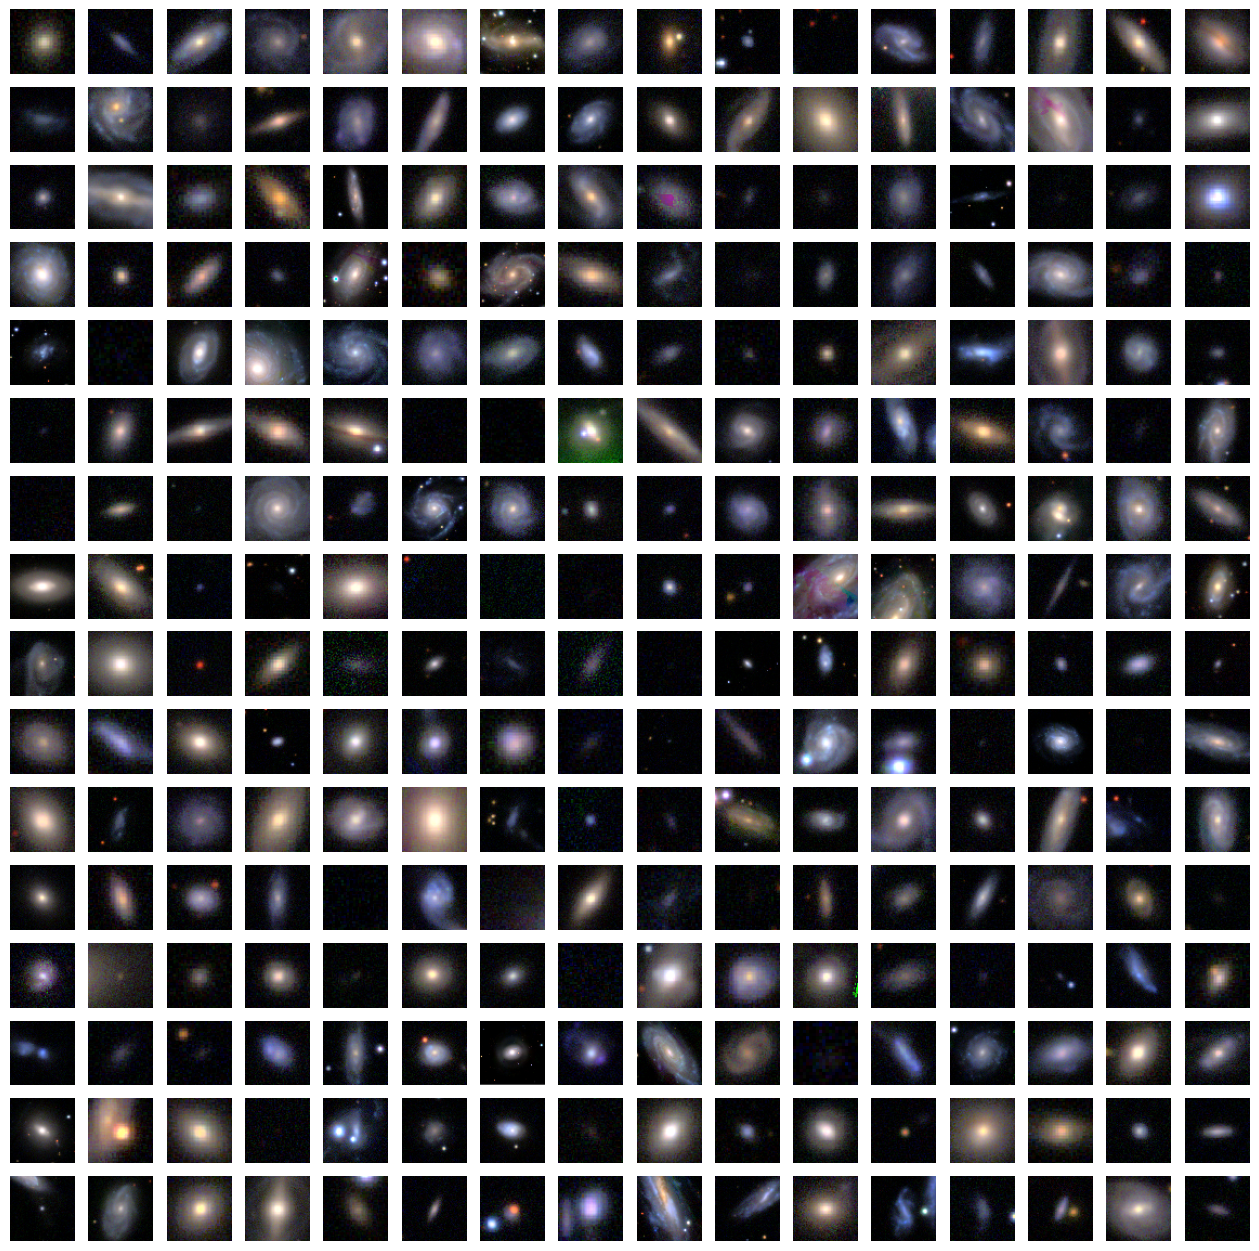

In [3]:
# Plot a grid of host galaxy images
fig, axs = plt.subplots(16, 16, figsize=(16, 16))
for i in range(16):
    for j in range(16):
        axs[i, j].imshow(host_imgs[i * 16 + j])
        axs[i, j].axis('off')

### Light curves (BTS sample)

Now let's at light curves.

In [4]:
dir_light_curves = "../data/ZTFBTS/light-curves/"

def open_light_curve_csv(filename):
    """ Helper function to open a light curve csv file.
    """
    file_path = os.path.join(dir_light_curves, filename)
    df = pd.read_csv(file_path)
    return df

light_curve_df = open_light_curve_csv("ZTF18aailmnv.csv")
light_curve_df.head()

,time,mag,magerr,band
0,58312.219097,20.132299,0.252360,R
1,58319.205984,18.713728,0.104188,g
2,58319.224942,18.808235,0.092660,R
3,58320.174525,18.467438,0.093920,g
4,58324.179444,18.514769,0.117073,R


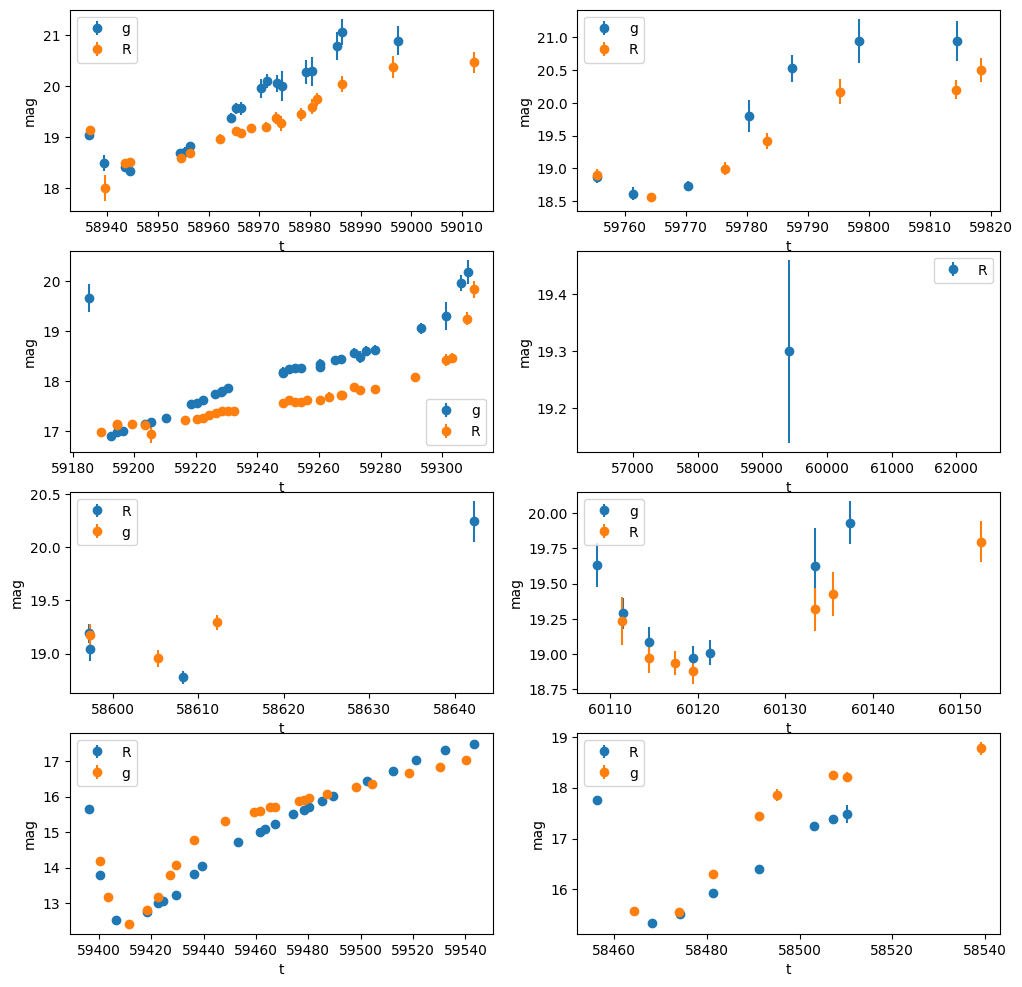

In [5]:
lightcurve_files = os.listdir(dir_light_curves)

# Plot a grid of light curves
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
for i in range(4):
    for j in range(2):
        light_curve_df = open_light_curve_csv(lightcurve_files[i * 2 + j])
        bands = light_curve_df['band'].unique()
        for band in bands:
            df_band = light_curve_df[light_curve_df['band'] == band]
            axs[i, j].errorbar(df_band['time'], df_band['mag'], yerr=df_band['magerr'], fmt='o', label=band)
        axs[i, j].set_xlabel("t")
        axs[i, j].set_ylabel("mag")
        axs[i, j].legend()

### Sample properties

With this smaller sample we also have access to some properties like the spectroscopic redshifts.

In [6]:
df_properties = pd.read_csv("../data/ZTFBTS/ZTFBTS_TransientTable.csv")
df_properties.head()

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,hostabs,hostcol,b,A_V
0,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,-20.72,0.64,27.562336,0.122
1,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,-22.70,1.06,59.641962,0.053
2,ZTF17aacldgo,SN2022zxv,03:09:24.35,-04:53:39.2,1897.75,g,18.7979,-18.91,>8.87,>3.85,>5.02,SN Ia,0.072,-20.57,0.99,-50.332472,0.183
3,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.062,-22.16,0.91,34.174702,0.106
4,ZTF18aaaibml,SN2020buc,10:08:31.27,+09:14:23.0,909.80,r,18.2606,-17.70,69.73,27.302,42.428,SN II,0.0348,-19.67,0.38,47.637802,0.092


Text(0, 0.5, 'count')

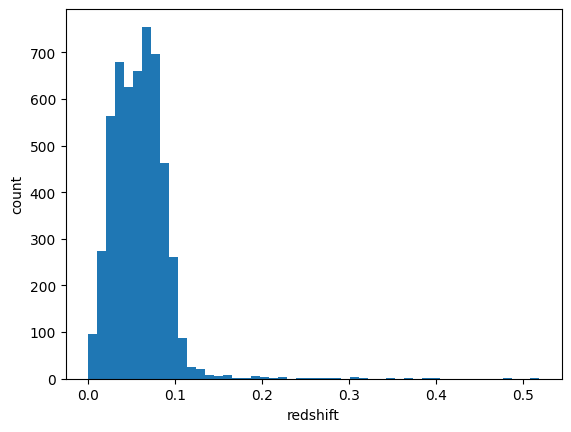

In [7]:
# Convert to float, if not possible then set to NaN
df_properties['redshift'] = pd.to_numeric(df_properties['redshift'], errors='coerce')

# Plot histogram of redshifts
plt.hist(df_properties['redshift'], bins=50);
plt.xlabel("redshift")
plt.ylabel("count")

### Light curves (bulk)

Now let's look at a few light curves from the bulk ZTF sample. These can be downloaded in bulk from [here](https://irsa.ipac.caltech.edu/Missions/ztf.html) (under "Lightcurve Bulk Download"). We've downloaded one `.parquet` file for now.

Data release notes: https://irsa.ipac.caltech.edu/data/ZTF/docs/releases/ztf_release_notes_latest.

In [8]:
import pyarrow.parquet as pq

In [9]:
# Load a bulk light curve sample
bulk_df = pq.read_table("../data/lightcurves_bulk/ztf_000858_zg_c01_q1_dr19.parquet").to_pandas()
bulk_df.head()

,objectid,filterid,fieldid,rcid,objra,objdec,nepochs,hmjd,mag,magerr,clrcoeff,catflags
0,858101100000000,1,858,0,121.166801,74.119148,181,"[58247.17837, 58347.49742, 58362.49149, 58368....","[20.790735, 20.31993, 20.606007, 21.471548, 21...","[0.20726836, 0.15888518, 0.18998587, 0.2709626...","[-0.08939283, -0.009556137, -0.006476993, -0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,858101100000001,1,858,0,119.970047,74.188736,610,"[58207.2526, 58207.2744, 58210.25232, 58229.15...","[16.1671, 16.162312, 16.10719, 16.154564, 16.1...","[0.014392191, 0.014376102, 0.014196091, 0.0143...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
2,858101100000002,1,858,0,120.869438,74.136711,610,"[58207.25263, 58207.27442, 58210.25234, 58229....","[16.092796, 16.05233, 16.037151, 16.08971, 16....","[0.014150625, 0.014026101, 0.01398062, 0.01414...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
3,858101100000003,1,858,0,121.366310,74.105324,598,"[58207.25264, 58207.27444, 58210.25236, 58229....","[17.77512, 17.661259, 17.747467, 17.815546, 17...","[0.02695156, 0.02533685, 0.026544018, 0.027565...","[-0.082320735, -0.08643703, -0.048796955, -0.0...","[0, 0, 0, 0, 32768, 0, 0, 0, 0, 32768, 0, 0, 0..."
5,858101100000005,1,858,0,121.104126,74.121140,379,"[58244.2015, 58247.17837, 58255.19753, 58346.4...","[20.145699, 20.32862, 20.048012, 20.142803, 19...","[0.14019924, 0.159865, 0.13053155, 0.13990413,...","[-0.0957851, -0.08939283, -0.0756015, -0.03298...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


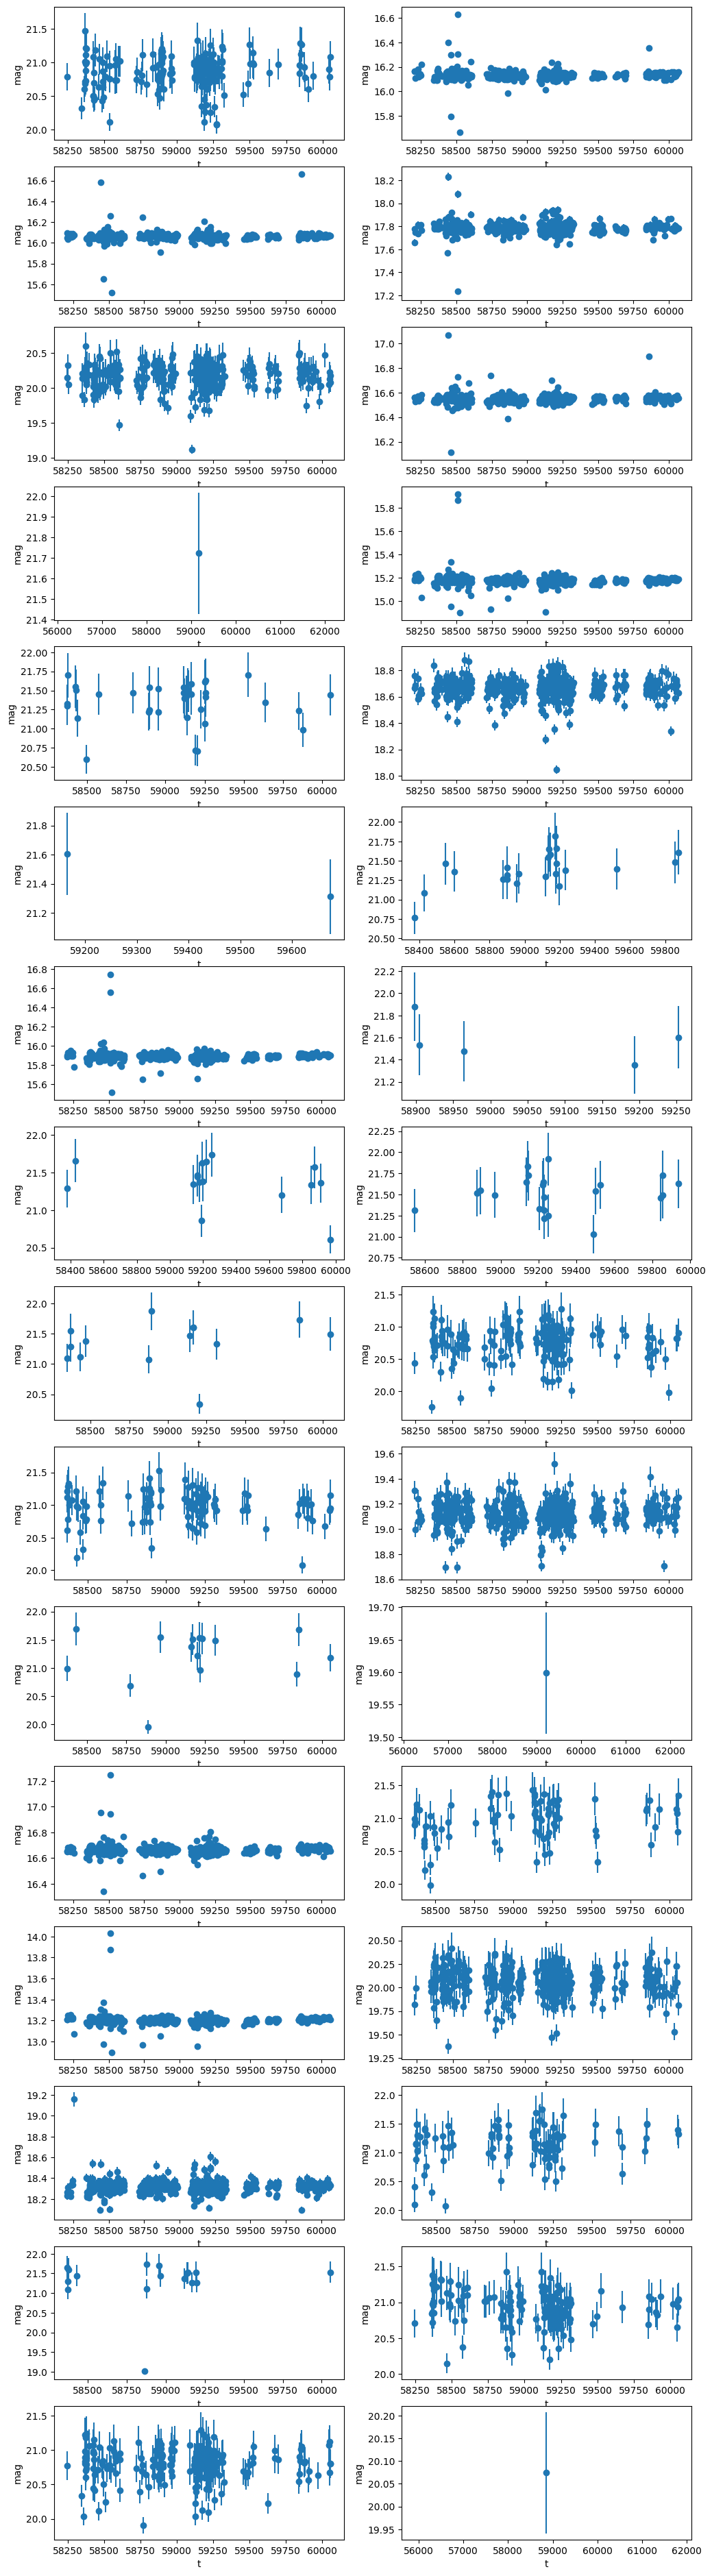

In [10]:
# Plot a grid of bulk light curves

n_row = 16
n_col = 2

fig, axs = plt.subplots(n_row, n_col, figsize=(12, 48))
for i in range(n_row):
    for j in range(n_col):
        row = bulk_df.iloc[i * n_col + j]
        axs[i, j].errorbar(row['hmjd'], row['mag'], yerr=row['magerr'], fmt='o')
        axs[i, j].set_xlabel("t")
        axs[i, j].set_ylabel("mag")

These clearly look different from the BTS sample already!